In [2]:
!pip install geopandas
!pip install earthpy
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 1.1 MB/s eta 0:00:01


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
from tqdm.notebook import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

%matplotlib inline

In [4]:
!wget --directory-prefix=../data/covid/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/covid/covid_month.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data_only_percents.csv
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape -d shape

# LA County Shapefile

In [5]:
# Graph neighbors of a region
def graph_neighbors(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)
    temp_n = df[df.region == region].neighbors.values[0].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df.plot_col = df.plot_col.mask(df['region'] == n, 2)
    ax = df.plot(column='plot_col', figsize=(10,10))
    green_patch = mpatches.Patch(color='green', label='Covering Polygon')
    yellow_patch = mpatches.Patch(color='yellow', label='Bordering Regions')
    purple_patch = mpatches.Patch(color='purple', label='Inner LA County')
    plt.legend(handles=[green_patch, yellow_patch, purple_patch])
#     ax.annotate()
#     df.apply(lambda x: ax.annotate(s=x.region, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    
# Graph region
def graph_region(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)

    df.plot(column='plot_col', figsize=(10,10), alpha=0.5)

In [6]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_filtered = la_shapes.rename(columns={'name':'region'})
la_filtered["neighbors"] = None  # add NEIGHBORS column
la_filtered["plot_col"] = 0 # Column used to graph neighbors
la_filtered = la_filtered[['region','geometry','neighbors','plot_col']]
la_filtered.head()

,region,geometry,neighbors,plot_col
0,Acton,"POLYGON ((-118.20262 34.53899, -118.18947 34.5...",None,0
1,Adams-Normandie,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",None,0
2,Agoura Hills,"POLYGON ((-118.76193 34.16820, -118.72632 34.1...",None,0
3,Agua Dulce,"POLYGON ((-118.25468 34.55830, -118.25551 34.5...",None,0
4,Alhambra,"POLYGON ((-118.12175 34.10504, -118.11687 34.1...",None,0


## Get bordering regions

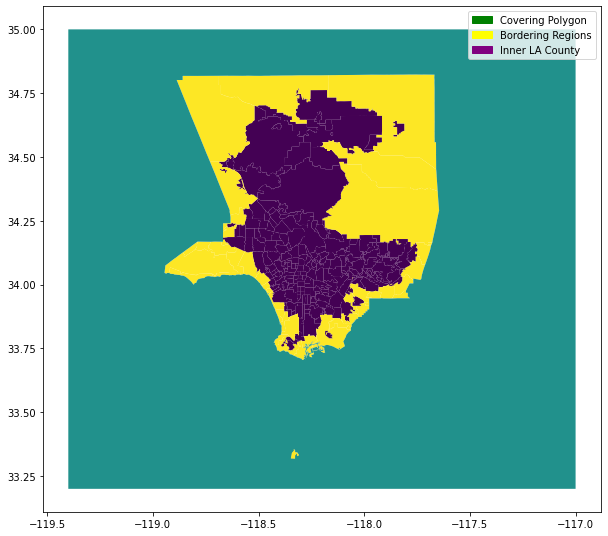

In [7]:
# Create a polygon that covers the entire la county region
cover = gpd.GeoSeries(Polygon([(-119.4,35), (-119.4,33.2), (-117,33.2), (-117,35)])).set_crs(epsg=4269)
# Remove Catalina Island since it is an island which has no neighbors
la_noisland = la_filtered[la_filtered['region']!='Unincorporated Catalina Island']
# Remove small holes within the la county unary union polygon
no_holes = MultiPolygon(Polygon(p.exterior) for p in la_noisland.geometry.unary_union)
no_holes_series = gpd.GeoSeries(no_holes).set_crs(epsg=4269)
# Subtract la county from the covering polygon
diff = gpd.GeoSeries.difference(cover, no_holes_series)
# We can find the cities that are touching 'diff' to locate border cities
# diff.plot(figsize=(5,5))
# Get neighbors of diff to obtain bordered regions
border_regions = la_filtered[~la_filtered.geometry.disjoint(diff[0])].region.tolist()
la_filtered.loc[len(la_filtered)] = ["COVER", diff[0], ", ".join(border_regions), 0]
graph_neighbors(la_filtered, 'COVER')
la_filtered = la_filtered[:-1]

## Get neighbors of each region

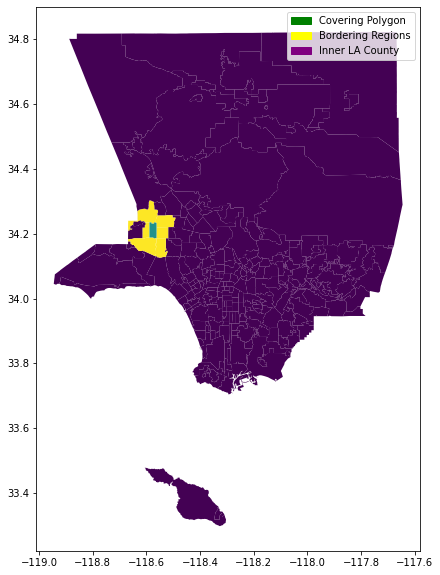

In [7]:
for index, row in la_filtered.iterrows():   
    # Get neighboring cities
    neighbors = la_filtered[~la_filtered.geometry.disjoint(row.geometry)].region.tolist()
    # Remove own name from list
    if row['region'] in neighbors:
        neighbors.remove(row['region'])
    la_filtered.at[index, "neighbors"] = ", ".join(neighbors)
graph_neighbors(la_filtered, 'Winnetka')
la_filtered = la_filtered[['region','neighbors','geometry']]

## Remove bordering regions

In [8]:
la_inner = la_filtered[~la_filtered['region'].isin(border_regions)]
la_inner.shape

(227, 3)

## Smooth/process COVID data

In [9]:
!wget --directory-prefix=../data/covid -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/covid/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_df = covid_df.rename(columns={'Region':'region', 'Number of cases':'cases'})
covid_df.head()

,Time Stamp,region,Latitude,Longitude,cases
0,03-16-2020,Alhambra,34.093042,-118.127060,2
1,03-16-2020,Arcadia,34.136208,-118.040150,1
2,03-16-2020,Beverly Hills,34.069650,-118.396306,1
3,03-16-2020,Boyle Heights,34.043689,-118.209768,5
4,03-16-2020,Carson,33.832204,-118.251755,1


In [10]:
# Set COVID cases to not be less than previously recorded - it should be a non-decreasing function
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    if prev_cases > row['cases']:
      covid_df.loc[idx, 'cases'] =  prev_cases
    else:
      prev_cases = row['cases']

In [11]:
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    covid_df.loc[idx, 'active_cases'] =  row['cases'] - prev_cases
    prev_cases = row['cases']
covid_df[covid_df['region'] == 'Alhambra']

,Time Stamp,region,Latitude,Longitude,cases,active_cases
0,03-16-2020,Alhambra,34.093042,-118.12706,2,2.0
31,03-17-2020,Alhambra,34.093042,-118.12706,2,0.0
73,03-18-2020,Alhambra,34.093042,-118.12706,2,0.0
118,03-19-2020,Alhambra,34.093042,-118.12706,2,0.0
188,03-20-2020,Alhambra,34.093042,-118.12706,3,1.0
...,...,...,...,...,...,...
51698,10-5-2020,Alhambra,34.093042,-118.12706,1439,0.0
51937,10-6-2020,Alhambra,34.093042,-118.12706,1439,0.0
52176,10-7-2020,Alhambra,34.093042,-118.12706,1439,0.0
52415,10-8-2020,Alhambra,34.093042,-118.12706,1439,0.0


## Fix inconsistencies in region name mapping

In [12]:
la_to_covid = {
    'Downtown': ['City', 'Pico', 'Wholesale District', 'Central', 'Little Tokyo', 'Temple-Beaudry'],
    'Silver Lake': ['Silverlake'],
    'Vernon': ['West Vernon', 'Vernon Central'],
    'Baldwin Hills/Crenshaw': ['Baldwin Hills'],
    'West Hollywood': ['Park LaBrea'],
    'Mid-Wilshire': ['Park LaBrea', 'Cloverdale/Cochran'],
    'Santa Clarity': ['Canyon Country'],
    'Echo Park': ['Angelino Heights'],
    'Avocado Heights': ['Bassett'],
    'Bel-Air': ['Bel Air'],
    'Arlington Heights': ['Country Club Park'],
    'Exposition Park': ['Exposition'],
    'Chinatown': ['Figueroa Park Square'],
    'Torrance': ['Gramercy Place'],
    'Harbor City': ['Harbor Pines'],
    'Mid-City': ['Lafayette Square', 'Mid-city', 'Reynier Village', 'Victoria Park', 'Wellington Square'],
    'Azusa': ['Lakeview Terrace'],
    'East Hollywood': ['Little Armenia'],
    'Playa Vista': ['Longwood'],
    'Brentwood': ['Mandeville Canyon'],
    'Playa del Rey': ['Playa Del Rey'],
    'Porter Ranch': ['Reseda Ranch'],
    'Carthay': ['South Carthay'],
    'Los Feliz': ['Thai Town'],
    'Toluca Lake': ['Toluca Terrace'],
    'El Sereno': ['University Hills'],
    'Angeles Crest': ['Angeles National Forest'],
    'Mount Washington': ['Mt. Washington']
}

for key, value in la_to_covid.items():
    covid_df.loc[covid_df['region'].isin(value), 'region'] = key

## Month aggregate

In [13]:
covid_df_month = covid_df[['Time Stamp', 'region', 'active_cases']]
covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_month = covid_df_month.set_index('Time Stamp')
covid_df_month = covid_df_month.groupby([pd.Grouper(freq='M'), 'region']).sum()
covid_df_month = covid_df_month.reset_index(level=['Time Stamp','region']).rename(columns={'Time Stamp': 'month'})
covid_df_month.month = covid_df_month.month.dt.month
covid_df_month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,month,region,active_cases
0,3,Acton,0.0
1,3,Adams-Normandie,5.0
2,3,Agoura Hills,11.0
3,3,Alhambra,13.0
4,3,Alsace,0.0
...,...,...,...
1725,10,Willowbrook,0.0
1726,10,Wilmington,175.0
1727,10,Wilshire Center,141.0
1728,10,Winnetka,267.0


In [14]:
covid_df[covid_df['region'] == 'East Los Angeles']

,Time Stamp,region,Latitude,Longitude,cases,active_cases
134,03-19-2020,East Los Angeles,34.023902,-118.172016,1,1.0
207,03-20-2020,East Los Angeles,34.023902,-118.172016,1,0.0
290,03-21-2020,East Los Angeles,34.023902,-118.172016,1,0.0
387,03-22-2020,East Los Angeles,34.023902,-118.172016,2,1.0
491,03-23-2020,East Los Angeles,34.023902,-118.172016,2,0.0
...,...,...,...,...,...,...
51754,10-5-2020,East Los Angeles,34.023902,-118.172016,7108,0.0
51993,10-6-2020,East Los Angeles,34.023902,-118.172016,7108,0.0
52232,10-7-2020,East Los Angeles,34.023902,-118.172016,7108,0.0
52471,10-8-2020,East Los Angeles,34.023902,-118.172016,7108,0.0


### Set low pop covid cases to 0

In [15]:
covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
population_df = pd.read_csv('../data/social_explorer_processed_data.csv')[['name','Total Population:']]
population_df = population_df.rename(columns={'name':'region', 'Total Population:': 'population'})
# population_df.plot.hist(by='region', figsize=(10,10))

Histogram of pop of regions w/ covid data

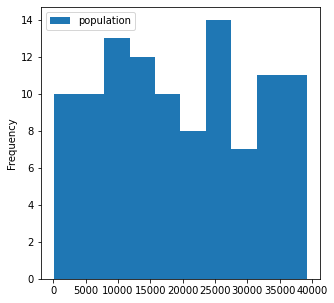

In [16]:
covid_population = population_df[population_df['region'].isin(pd.unique(covid_df.region))]
covid_population[covid_population.population <= 40000].plot.hist(by='region', figsize=(5,5), bins=10)

Histogram of pop of regions w/ missing covid data

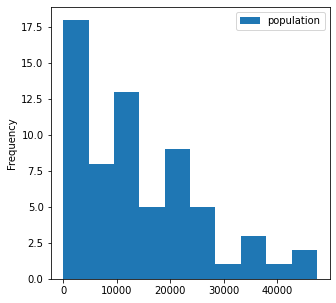

In [17]:
check_df = population_df.assign(InDf2=population_df.region.isin(covid_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
covid_no_data = population_df[population_df['region'].isin(miss_arr)]
covid_no_data[covid_no_data.population <= 100000].plot.hist(by='region', figsize=(5,5), bins=10)

Smaller regions have more missing data in general, but there are also outliers

Small regions w/ a lot of covid cases

In [18]:
small_pop_region = population_df[population_df['population'] <= 5000]['region'].values
pd.unique(covid_df_month[covid_df_month.region.isin(small_pop_region)].region)
covid_df_month[covid_df_month.region.isin(small_pop_region)].groupby('region').sum()

,month,active_cases
region,,
Angeles Crest,52,2.0
Avalon,52,31.0
Bel-Air,52,107.0
Beverlywood,52,194.0
Bradbury,52,20.0
Century City,52,138.0
Elysian Park,52,111.0
Harvard Park,52,1799.0
Irwindale,52,79.0


Big regions w/ no covid cases

In [19]:
print(covid_no_data[covid_no_data.population >= 30000].region.values)

['Castaic Canyons' 'Central-Alameda' 'Historic South-Central' 'Long Beach'
 'Sawtelle' 'Vermont-Slauson' 'Westmont']


### Remove regions w/ missing neighbors & their neighbors

In [20]:
covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
check_df = la_inner.assign(InDf2=la_inner.region.isin(covid_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
miss_set = set(miss_arr)
for region in miss_arr:
    temp_n = la_inner[la_inner.region == region].neighbors.values[0].split(',')
    temp_n = set([n.strip() for n in temp_n])
    miss_set = miss_set | temp_n
miss_arr = list(miss_set)
la_inner = la_inner[~la_inner['region'].isin(miss_arr)]
la_inner.shape

(52, 3)

# Aggregate Covid Data

## Census data

In [21]:
census_data = pd.read_csv('../data/social_explorer_processed_data_only_percents.csv')
census_data.shape

(261, 168)

In [22]:
census_data.dropna().dtypes

name                                           object
% Area Total: Area (Land)                     float64
% Area Total: Area (Water)                    float64
% Total Population: Under 5 Years             float64
% Total Population: 5 to 9 Years              float64
                                               ...   
% Households10: 3-Person Household            float64
% Households10: 4-Person Household            float64
% Households10: 5-Person Household            float64
% Households10: 6-Person Household            float64
% Households10: 7-or-More Person Household    float64
Length: 168, dtype: object

In [23]:
# Get all regions that have data
census_unique_regions = pd.DataFrame(data=pd.unique(census_data.name),columns=['region'])
regions = pd.merge(covid_unique_regions, la_inner[['region']], on='region', how='inner')
regions = pd.merge(regions, census_unique_regions, on='region', how='inner')['region'].values
len(regions)

52

In [24]:
used_features = [
  'name',
  '% Area Total: Area (Land)',
  '% Area Total: Area (Water)',
  '% Total Population: Under 5 Years',
  '% Total Population: 5 to 9 Years',
  '% Total Population: 10 to 14 Years',
  '% Total Population: 15 to 17 Years',
  '% Total Population: 18 to 24 Years',
  '% Total Population: 25 to 34 Years',
  '% Total Population: 35 to 44 Years',
  '% Total Population: 45 to 54 Years',
  '% Total Population: 55 to 64 Years',
  '% Total Population: 65 to 74 Years',
  '% Total Population: 75 to 84 Years',
  '% Total Population: 85 Years and Over',
  '% Households: Family Households',
  '% Households: Family Households: Married-Couple Family',
  '% Households: Family Households: Other Family',
  '% Households: Family Households: Other Family: Male Householder, No Wife Present',
  '% Households: Family Households: Other Family: Female Householder, No Husband Present',
  '% Households: Nonfamily Households',
  '% Households: Nonfamily Households: Male Householder',
  '% Households: Nonfamily Households: Female Householder',
  '% Population 16 Years and Over: in Labor Force',
  '% Population 16 Years and Over: in Labor Force: in Armed Forces',
  '% Population 16 Years and Over: in Labor Force: Civilian',
  '% Population 16 Years and Over: in Labor Force: Civilian: Employed',
  '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed',
  '% Population 16 Years and Over: Not in Labor Force',
  '% In Labor Force 16 Years and Over: in Armed Forces',
  '% In Labor Force 16 Years and Over: Civilian',
  '% Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining',
  '% Employed Civilian Population 16 Years and Over: Construction',
  '% Employed Civilian Population 16 Years and Over: Manufacturing',
  '% Employed Civilian Population 16 Years and Over: Wholesale Trade',
  '% Employed Civilian Population 16 Years and Over: Retail Trade',
  '% Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities',
  '% Employed Civilian Population 16 Years and Over: Information',
  '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing',
  '% Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services',
  '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance',
  '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services',
  '% Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration',
  '% Employed Civilian Population 16 Years and Over: Public Administration',
  '% Employed Civilian Population 16 Years and Over1: Private Sector',
  '% Employed Civilian Population 16 Years and Over1: Public Sector',
  '% Employed Civilian Population 16 Years and Over1: Self-Employed (Incorporated and Not Incorporated)',
  '% Employed Civilian Population 16 Years and Over1: Private Non-Profit',
  '% Employed Civilian Population 16 Years and Over1: Unpaid Family Workers',
  '% Households1: with Earnings', '% Households1: No Earnings',
  '% Households2: with Wage or Salary Income',
  '% Households2: No Wage or Salary Income',
  '% Households3: with Self-Employment Income',
  '% Households3: No Self-Employment Income',
  '% Households4: with Interest, Dividends, or Net Rental Income',
  '% Households4: No Interest, Dividends, or Net Rental Income',
  '% Households5: with Social Security Income',
  '% Households5: No Social Security Income',
  '% Households6: with Supplemental Security Income (Ssi)',
  '% Households6: No Supplemental Security Income (Ssi)',
  '% Households7: with Public Assistance Income',
  '% Households7: No Public Assistance Income',
  '% Households8: with Retirement Income',
  '% Households8: No Retirement Income',
  '% Households9: with Other Types of Income',
  '% Households9: No Other Types of Income',
  '% Families: Income Below Poverty Level',
  '% Families: Income Below Poverty Level: Married Couple Family: with Related Child Living  Bellow Poverty Level',
  '% Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years',
  '% Families: Income At or Above Poverty Level',
  '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty',
  '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level',
  '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty',
  '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level',
  '% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty',
  '% Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level',
  '% Population for Whom Poverty Status Is Determined: Under .50',
  '% Population for Whom Poverty Status Is Determined: .50 to .74',
  '% Population for Whom Poverty Status Is Determined: .75 to .99',
  '% Population for Whom Poverty Status Is Determined: 1.00 to 1.49',
  '% Population for Whom Poverty Status Is Determined: 1.50 to 1.99',
  '% Population for Whom Poverty Status Is Determined: 2.00 and Over',
  '% Population for Whom Poverty Status Is Determined1: Under 1.00 (Doing Poorly)',
  '% Population for Whom Poverty Status Is Determined1: 1.00 to 1.99 (Struggling)',
  '% Population for Whom Poverty Status Is Determined1: Under 2.00 (Poor or Struggling)',
  '% Population for Whom Poverty Status Is Determined1: 2.00 and Over (Doing Ok)',
  '% White Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  '% White Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level',
  '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  '% Asian Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income Below Poverty Level',
  '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% Two or More Races Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Two or More Races Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Workers 16 Years and Over: Car, Truck, or Van',
  '% Workers 16 Years and Over: Drove Alone',
  '% Workers 16 Years and Over: Carpooled',
  '% Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
  '% Workers 16 Years and Over: Motorcycle',
  '% Workers 16 Years and Over: Bicycle',
  '% Workers 16 Years and Over: Walked',
  '% Workers 16 Years and Over: Other Means',
  '% Workers 16 Years and Over: Worked At Home',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Drove Alone',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Carpooled',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Public Transportation (Excluding Taxicab)',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Walked',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Taxicab, Motorcycle, Bicycle, or Other Means',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Worked At Home',
  '% Workers 16 Years and Over2: Did Not Work At Home',
  '% Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 10 to 19 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 20 to 29 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 30 to 39 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 40 to 59 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 60 to 89 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 90 or More Minutes',
  '% Workers 16 Years and Over2: Worked At Home',
  '% Total: No Health Insurance Coverage',
  '% Total: with Health Insurance Coverage',
  '% Total: with Health Insurance Coverage: Public Health Coverage',
  '% Total: with Health Insurance Coverage: Private Health Insurance',
  '% Population Under 18: No Health Insurance Coverage',
  '% Population Under 18: with Health Insurance Coverage',
  '% Population Under 18: with Health Insurance Coverage: Public Health Coverage',
  '% Population Under 18: with Health Insurance Coverage: Private Health Insurance',
  '% Population 18 to 24: No Health Insurance Coverage',
  '% Population 18 to 24: with Health Insurance Coverage',
  '% Population 18 to 24: with Health Insurance Coverage: Public Health Coverage',
  '% Population 18 to 24: with Health Insurance Coverage: Private Health Insurance',
  '% Population 25 to 34: No Health Insurance Coverage',
  '% Population 25 to 34: with Health Insurance Coverage',
  '% Population 25 to 34: with Health Insurance Coverage: Public Health Coverage',
  '% Population 25 to 34: with Health Insurance Coverage: Private Health Insurance',
  '% Population 35 to 64: No Health Insurance Coverage',
  '% Population 35 to 64: with Health Insurance Coverage',
  '% Population 35 to 64: with Health Insurance Coverage: Public Health Coverage',
  '% Population 35 to 64: with Health Insurance Coverage: Private Health Insurance',
  '% Population 65 or Older: No Health Insurance Coverage',
  '% Population 65 or Older: with Health Insurance Coverage',
  '% Population 65 or Older: with Health Insurance Coverage: Public Health Coverage',
  '% Population 65 or Older: with Health Insurance Coverage: Private Health Insurance',
  '% Own Children under 18 Years: Children Living with Single Parents',
  '% Households10: 1-Person Household',
  '% Households10: 2-Person Household',
  '% Households10: 3-Person Household',
  '% Households10: 4-Person Household',
  '% Households10: 5-Person Household',
  '% Households10: 6-Person Household',
  '% Households10: 7-or-More Person Household'
]

for feature in census_data.columns:
  if feature not in used_features:
    del census_data[feature]
    print("Deleted ", feature)

census_data.head()
feature_names = np.concatenate((['cases', 'Neighbor cases', 'County total cases'], census_data.columns.values[1:]))
feature_names

array(['cases', 'Neighbor cases', 'County total cases',
       '% Area Total: Area (Land)', '% Area Total: Area (Water)',
       '% Total Population: Under 5 Years',
       '% Total Population: 5 to 9 Years',
       '% Total Population: 10 to 14 Years',
       '% Total Population: 15 to 17 Years',
       '% Total Population: 18 to 24 Years',
       '% Total Population: 25 to 34 Years',
       '% Total Population: 35 to 44 Years',
       '% Total Population: 45 to 54 Years',
       '% Total Population: 55 to 64 Years',
       '% Total Population: 65 to 74 Years',
       '% Total Population: 75 to 84 Years',
       '% Total Population: 85 Years and Over',
       '% Households: Family Households',
       '% Households: Family Households: Married-Couple Family',
       '% Households: Family Households: Other Family',
       '% Households: Family Households: Other Family: Male Householder, No Wife Present',
       '% Households: Family Households: Other Family: Female Householder, No Husban

### Data w/o census

In [25]:
month_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_month.month)
# List of month case sums
covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        # Get cases for current region
        region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases, fill missing neighbor data with avg of other neighbors
        neighbors = (la_inner[la_inner['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['active_cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(month_data_no_census.shape) == 1:
            month_data_no_census = np.array([row_data])
        else:
            month_data_no_census = np.append(month_data_no_census, [row_data], axis=0)
month_data_no_census

array([[3.0000e+00, 1.3000e+01, 2.2000e+01, 2.4500e+03, 3.1000e+01],
       [3.0000e+00, 1.1000e+01, 9.3000e+01, 2.4500e+03, 1.9000e+02],
       [3.0000e+00, 1.2000e+01, 9.2000e+01, 2.4500e+03, 1.4600e+02],
       ...,
       [8.0000e+00, 1.2000e+01, 6.2800e+02, 5.0431e+04, 9.0000e+00],
       [8.0000e+00, 6.1000e+01, 6.1000e+01, 5.0431e+04, 3.2000e+01],
       [8.0000e+00, 7.0000e+01, 1.3980e+03, 5.0431e+04, 6.3000e+01]])

In [26]:
month_data_no_census.shape

(312, 5)

Data with census

In [27]:
def build_month_data_with_census(census_data):
  month_data_with_census = np.array([])
  # List of months
  time_frames = pd.unique(covid_df_month.month)
  # List of month case sums
  covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

  for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
      time_frame = time_frames[i]
      for region in regions:
          # Build current row of data
          row_data = np.array([time_frame])
          # Get cases for current region
          region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
          if len(region_cases) == 0:
              region_cases = 0
          else:
              region_cases = region_cases[0]
          row_data = np.append(row_data, [region_cases])
          
          # Get neighbors cases, fill missing neighbor data with avg of other neighbors
          neighbors = (la_inner[la_inner['region']==region]['neighbors']).values[0]
          neighbors = neighbors.split(',')
          neighbors = [neighbor.strip() for neighbor in neighbors]
          neighbors_cases = 0
          no_data_count = 0
          for neighbor in neighbors:
              neighbor_cases_arr= covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['active_cases'].values
              if len(neighbor_cases_arr) != 0:
                  neighbors_cases += neighbor_cases_arr[0]
              else:
                  no_data_count += 1
          if no_data_count == len(neighbors):
              neighbors_cases += region_cases * len(neighbors)
          else:
              neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
          row_data = np.append(row_data, [neighbors_cases])
          
          # Get cases of the entire LA region
          total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
          row_data = np.append(row_data, [total_cases])
          
          # Get census data
          census_row = census_data[census_data['name']==region].values[0][1:]/100
          row_data = np.append(row_data, census_row)
          
          # Get cases for next time_frame
          next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
          # This data is not available yet
          if len(next_cases) == 0:
              next_cases = 0
          else:
              next_cases = next_cases[0]
          row_data = np.append(row_data, [next_cases])
          
          # Add data to numpy arr
          if len(month_data_with_census.shape) == 1:
              month_data_with_census = np.array([row_data])
          else:
              month_data_with_census = np.append(month_data_with_census, [row_data], axis=0)
  month_data_with_census = month_data_with_census.astype(float)
  month_data_with_census[:,~np.isnan(month_data_with_census).any(axis=0)].shape
  return month_data_with_census

month_data_with_census = build_month_data_with_census(census_data)
month_data_with_census

array([[3.00000000e+00, 1.30000000e+01, 2.20000000e+01, ...,
        2.21225405e-02, 1.25055221e-02, 3.10000000e+01],
       [3.00000000e+00, 1.10000000e+01, 9.30000000e+01, ...,
        6.49930379e-02, 6.79416824e-02, 1.90000000e+02],
       [3.00000000e+00, 1.20000000e+01, 9.20000000e+01, ...,
        3.58642972e-02, 1.95245788e-02, 1.46000000e+02],
       ...,
       [8.00000000e+00, 1.20000000e+01, 6.28000000e+02, ...,
        2.20381110e-02, 1.82270091e-03, 9.00000000e+00],
       [8.00000000e+00, 6.10000000e+01, 6.10000000e+01, ...,
        3.07034590e-02, 1.12708900e-02, 3.20000000e+01],
       [8.00000000e+00, 7.00000000e+01, 1.39800000e+03, ...,
        8.71640552e-03, 0.00000000e+00, 6.30000000e+01]])

In [28]:
month_data_with_census.dtype

dtype('float64')

In [29]:
## Load data
# month_data_no_census #  = np.load('data/covid/covid_month_no_census_filtered.npy', allow_pickle=True)
# month_data_with_census#  = np.load('data/covid/covid_month_with_census_filtered.npy',allow_pickle=True)
# month_data_with_census = np.loadtxt('../data/covid/covid_month_with_census_filtered.csv', delimiter=",")
print(month_data_no_census.shape, month_data_with_census.shape)
month_data_df = pd.read_csv('data/covid/covid_month.csv')
month_data_df.head()

(312, 5) (312, 172)


,Unnamed: 0,month,region,cases
0,0,3,Acton,0
1,1,3,Adams-Normandie,5
2,2,3,Agoura Hills,56
3,3,3,Alhambra,90
4,4,3,Alsace,0


# Naive train-test split

In [30]:
def our_split(month_data_with_census):
  month_no_census_X = month_data_no_census[:, 1:]
  month_no_census_X = month_no_census_X[:,:-1]
  month_no_census_y = month_data_no_census[:, -1]

  month_with_census_X = month_data_with_census[:, 1:]
  month_with_census_X = month_with_census_X[:,:-1]
  month_with_census_y = month_data_with_census[:, -1]

  print(month_no_census_X.shape, month_with_census_X.shape)
  month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = train_test_split(
      month_no_census_X, month_no_census_y, test_size=0.4, random_state=42)
  month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = train_test_split(
      month_with_census_X, month_with_census_y, test_size=0.4, random_state=42)
  return month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test


In [31]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = our_split(month_data_with_census)

(312, 3) (312, 170)


# Time Validation

In [32]:
def transform_data(data):
    pt = PowerTransformer()
    if len(data.shape) == 1:
        transformed_data = pt.fit_transform(data.reshape(-1,1))
        return (transformed_data.reshape(-1,), pt)
    transformed_data = pt.fit_transform(data)
    return (transformed_data, pt)
def apply_transform(model, data):
    if len(data.shape) == 1:
        return model.transform(data.reshape(-1,1)).reshape(-1,)
    return model.transform(data)

In [33]:
def one_time_split(data):
    # Index of first row with month == 4
    first_index = np.where(data[:,0]==4)[0][0]
    print(first_index)
    # Index of first row with month == 8
    last_index = np.where(data[:,0] == 8)[0][0]
    
    # Split into train test
    X_train = data[first_index:last_index, 1:-1]
    X_test = data[last_index:, 1:-1]
    y_train = data[first_index:last_index, -1]
    y_test = data[last_index:, -1]
    
    # Feature transformation
    ## Transformation should be done on the training set and applied on testing set
    X_train, pt_X = transform_data(X_train)
    X_test = apply_transform(pt_X, X_test)
    y_train, pt_y = transform_data(y_train)
    y_test = apply_transform(pt_y, y_test)
    
    return(X_train,X_test,y_train,y_test)

In [34]:
def multiple_time_split(data):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    for i in range(4,7):
        train_start_index = np.where(data[:,0]==i)[0][0]
        test_start_index = np.where(data[:,0]==i+2)[0][0]
        test_end_index = np.where(data[:,0]==i+3)[0][0] if i!=6 else data.shape[0]
        X_train = data[train_start_index:test_start_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:test_start_index, -1]
        y_test = data[test_start_index:test_end_index, -1]
        
        print('============')
        print(train_start_index, test_start_index, test_end_index)
        print('============')
        
        # Feature transformation
        ## Transformation should be done on the training set and applied on testing set
        X_train, pt_X = transform_data(X_train)
        X_test = apply_transform(pt_X, X_test)
        y_train, pt_y = transform_data(y_train)
        y_test = apply_transform(pt_y, y_test)
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr)

In [35]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = one_time_split(
    month_data_no_census)
print(month_no_census_X_test.shape)

52
(52, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [36]:
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = one_time_split(
    month_data_with_census)
print(month_with_census_X_test.shape)

52


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


(52, 170)


In [37]:
month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr = multiple_time_split(
    month_data_no_census)
print(month_no_census_X_train_arr[1].shape)

52 156 208
104 208 260
156 260 312
(104, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [38]:
month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr = multiple_time_split(
    month_data_with_census)
print(month_with_census_X_train_arr[2].shape)

52 156 208


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


104 208 260


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


156 260 312
(104, 170)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


# Model Training

In [39]:
def one_split_model(X_train, X_test, y_train, y_test, model, graph_title):
    # Error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    error = {
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    
    # Graph
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()
#     print(sorted(model.cv_results_.keys()))
    return r2


In [40]:
def multiple_split_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
        
#         feat_im = np.array(model.feature_importances_)
#         feat_im_indices = feat_im.argsort()[-10:]
#         important_features = feature_names[feat_im_indices]
#         plt.figure()
#         plt.title("Feature importances")
#         plt.barh(range(len(important_features)), feat_im[feat_im_indices],
#                color="r", align="center")
#         plt.yticks(range(len(important_features)), important_features)
#         plt.ylim([-1, len(important_features)])
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr))
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for test set in month {m}'.format(m=i+6))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

# Linear Reg

In [41]:
lin_model = LinearRegression()

MSE: 0.43361981291865176 
r2: 0.40864091388834856 
MAE: 0.6095860582112473 
avg: -0.3739842107738299


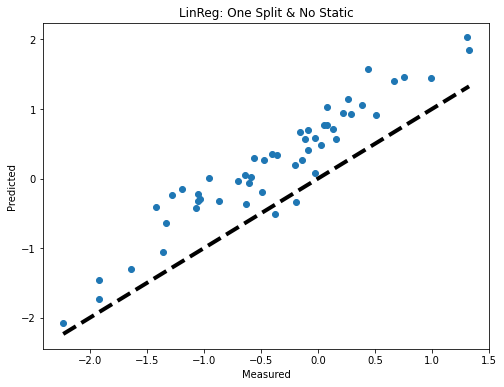

0.40864091388834856

In [42]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, lin_model, "LinReg: One Split & No Static")

MSE: 0.3236735316710565 
r2: 0.6488436252668448 
MAE: 0.4921712089081704 
avg: -0.3739842107738299


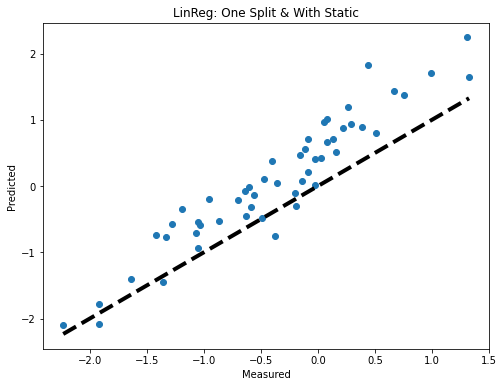

0.6488436252668448

In [43]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, lin_model, "LinReg: One Split & With Static")

MSE: [0.08913651877125459, 0.5276616119566436, 0.6987869289863701] 
r2: [0.9275278262973917, 0.504934226983365, 0.10058812602812817] 
MAE: [0.22897807195976375, 0.6840613258007784, 0.788039800122318] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


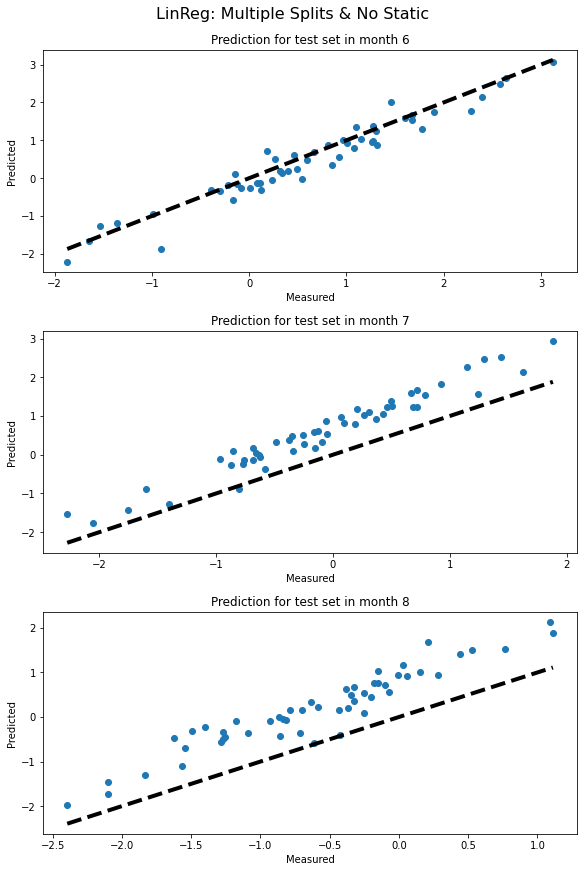

In [44]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, lin_model, "LinReg: Multiple Splits & No Static")

MSE: [0.2685390961988595, 0.44944363199773557, 0.6204795971935897] 
r2: [0.7777587294781179, 0.5970501933536723, 0.3633210610853578] 
MAE: [0.4332548236116406, 0.5901036754669549, 0.7043069117421494] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


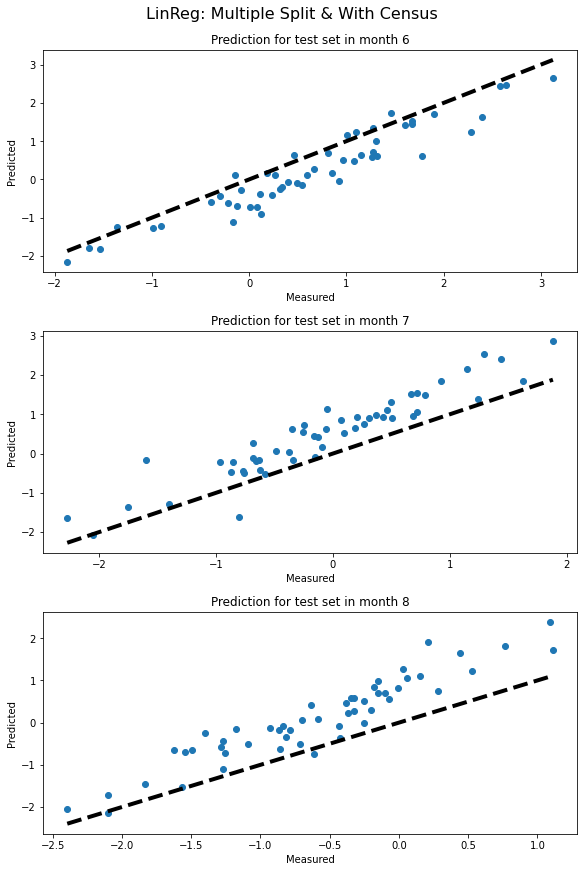

In [45]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, lin_model, "LinReg: Multiple Split & With Census")

# SVR

In [46]:
# svr_params = {
#     'C': 10,
# }

svr_params = {
    'C': 20,
    'gamma': 0.01,
    # 'kernel': 'linear',
}

svr_param_grid = {
    'C':[10, 100, 1000, 10000],
    "gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'kernel': ['poly'],
    'degree':[3,5,7]
}

svr_model = SVR(**svr_params)
svr_search = GridSearchCV(svr_model, svr_param_grid)
print(month_no_census_X_train.shape)
print(month_with_census_X_train.shape)

(208, 3)
(208, 170)


MSE: 0.42943522482478347 
r2: 0.4008246616130895 
MAE: 0.5992520043760922 
avg: -0.3739842107738299


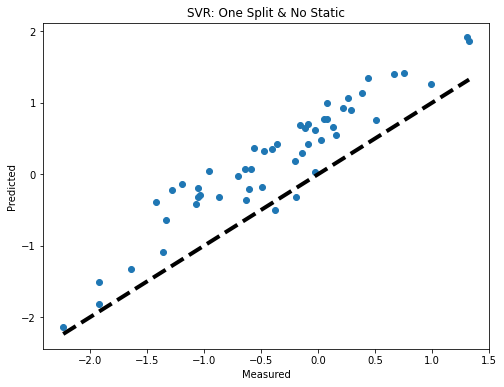

0.4008246616130895

In [47]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, svr_model, "SVR: One Split & No Static")

MSE: 0.2909861965630146 
r2: 0.6712557220499398 
MAE: 0.47110294661870833 
avg: -0.3739842107738299


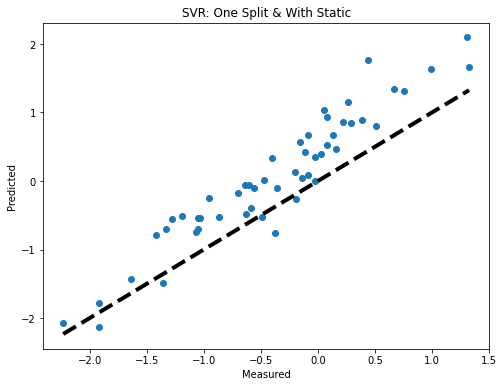

0.6712557220499398

In [48]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, svr_model, "SVR: One Split & With Static")

MSE: [0.07818967730018757, 0.5482640273332549, 0.7571482663253057] 
r2: [0.9342237213832324, 0.4805128369717404, 0.13922756671665015] 
MAE: [0.22793910758158276, 0.6991468372086437, 0.8139892476171126] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


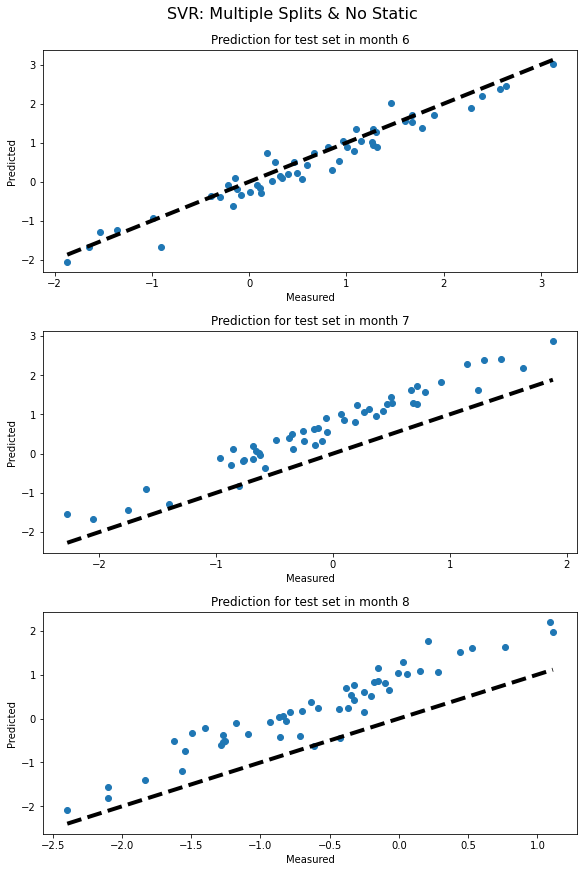

In [49]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, svr_model, "SVR: Multiple Splits & No Static")

MSE: [0.22280394825502514, 0.2711885496201334, 0.6461666167551718] 
r2: [0.8091971952501078, 0.7606572025892071, 0.3661954524980948] 
MAE: [0.39632806955773314, 0.4592494222895199, 0.7113171856421914] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


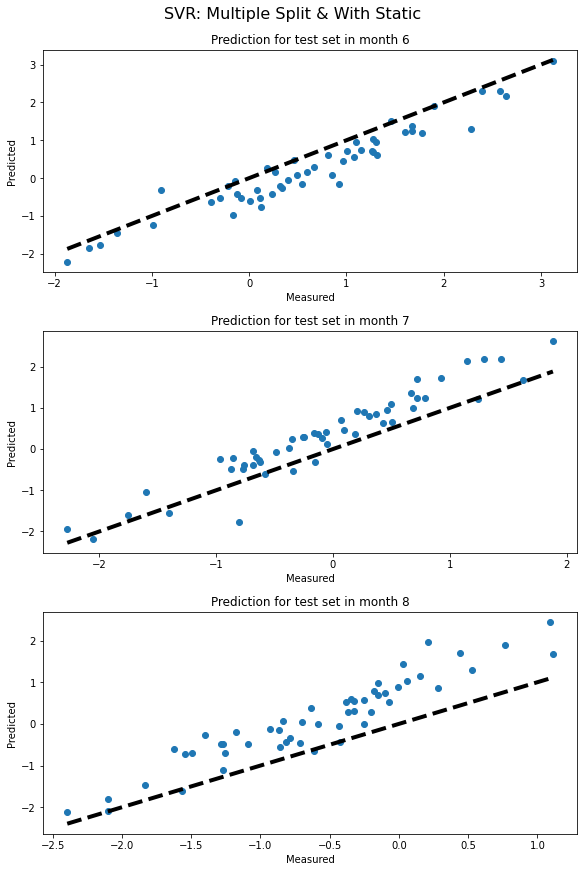

In [50]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, svr_model, "SVR: Multiple Split & With Static")

52
MSE: 0.42943522482478347 
r2: 0.4008246616130895 
MAE: 0.5992520043760922 
avg: -0.3739842107738299


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


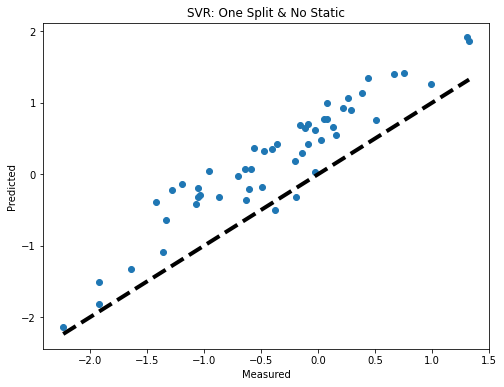

[0, 1]
['cases' 'Neighbor cases']
52


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


MSE: 0.2909861965630146 
r2: 0.6712557220499398 
MAE: 0.47110294661870833 
avg: -0.3739842107738299


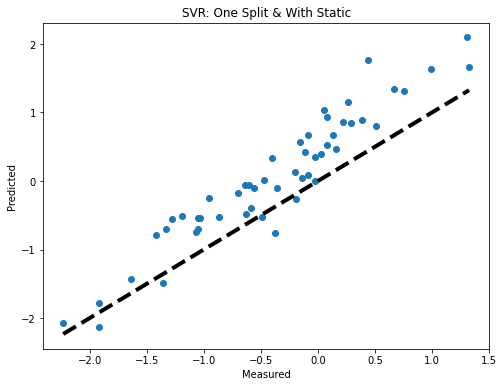

Choosing:  162  top features
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 164, 165, 167, 168, 169]
['cases' 'Neighbor cases' 'County total cases' '% Area Total: Area (Land)'
 '% Area Total: Area (Water)' '% Total Population: Under 5 Years'
 '% Total Population: 5 to 9 Years' '% Total Population: 10 to 14 Years'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population:

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


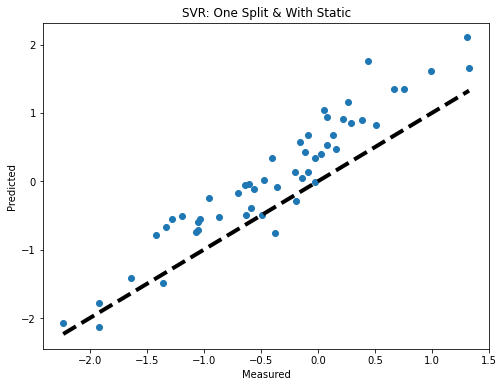

Choosing:  152  top features
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]
['cases' 'Neighbor cases' 'County total cases' '% Area Total: Area (Land)'
 '% Area Total: Area (Water)' '% Total Population: Under 5 Years'
 '% Total Population: 5 to 9 Years' '% Total Population: 10 to 14 Years'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 45 to 54 Years' '% Total Population: 55 to 64 Years'


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


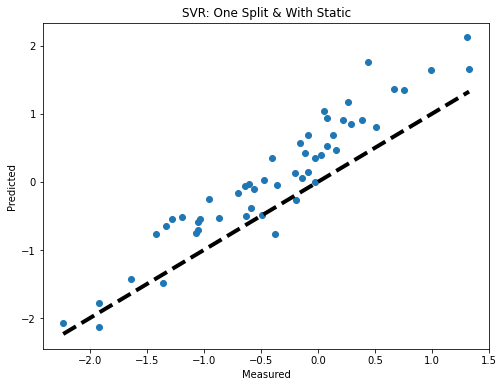

Choosing:  142  top features
[0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141]
['cases' 'Neighbor cases' 'County total cases' '% Area Total: Area (Land)'
 '% Area Total: Area (Water)' '% Total Population: Under 5 Years'
 '% Total Population: 10 to 14 Years' '% Total Population: 18 to 24 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 65 to 74 Years' '% Total Population: 75 to 84 Years'
 '% Total Population: 85 Years and Over'
 '% H

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


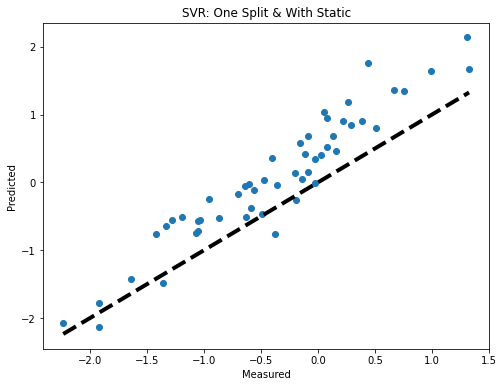

Choosing:  132  top features
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
['cases' 'Neighbor cases' 'County total cases' '% Area Total: Area (Land)'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 55 to 64 Years' '% Total Population: 65 to 74 Years'
 '% Total Population: 75 to 84 Years'
 '% Total Population: 85 Years and Over'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Househol

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


MSE: 0.305484431864717 
r2: 0.6572988060237885 
MAE: 0.4840151940894396 
avg: -0.3739842107738299


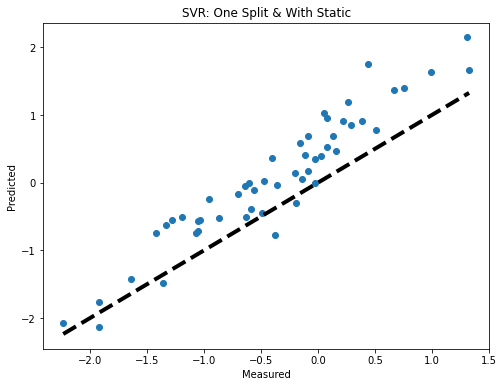

Choosing:  122  top features
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121]
['cases' 'Neighbor cases' 'County total cases' '% Area Total: Area (Land)'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 55 to 64 Years' '% Total Population: 65 to 74 Years'
 '% Total Population: 75 to 84 Years'
 '% Total Population: 85 Years and Over'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family'
 '% Households: Family Households

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


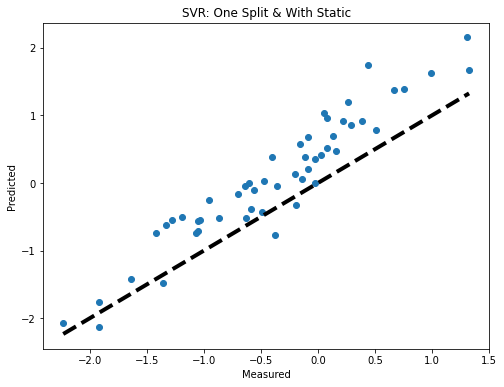

Choosing:  112  top features
[0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
['cases' 'Neighbor cases' 'County total cases'
 '% Area Total: Area (Water)' '% Total Population: 18 to 24 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 65 to 74 Years' '% Total Population: 75 to 84 Years'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Population

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


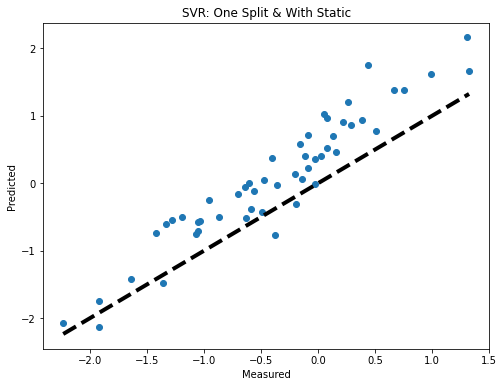

Choosing:  102  top features
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101]
['cases' 'Neighbor cases' 'County total cases'
 '% Area Total: Area (Water)' '% Total Population: 18 to 24 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 65 to 74 Years' '% Total Population: 75 to 84 Years'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% Population 16 Years and Over: in Labor Force: Civilian: Emp

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


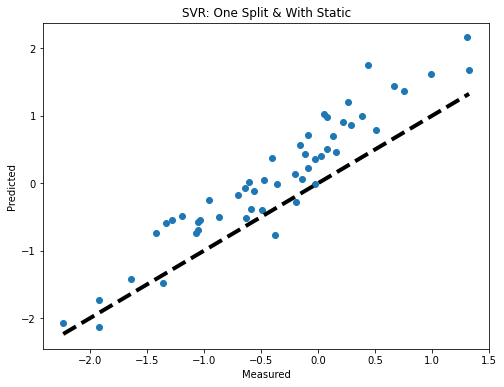

Choosing:  92  top features
[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 56, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 65 to 74 Years' '% Total Population: 75 to 84 Years'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% Population 16 Years and Over: in Labor Force: Civilian: Employed'
 '% Population 16 Years and Over: Not in Labor Force'
 '% Employed Civilian Population 16 Years and Ov

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


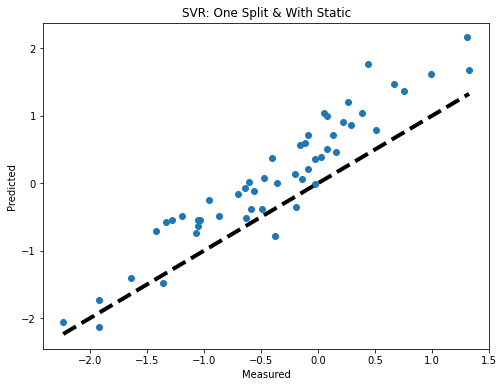

Choosing:  82  top features
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 65 to 74 Years' '% Total Population: 75 to 84 Years'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Le

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


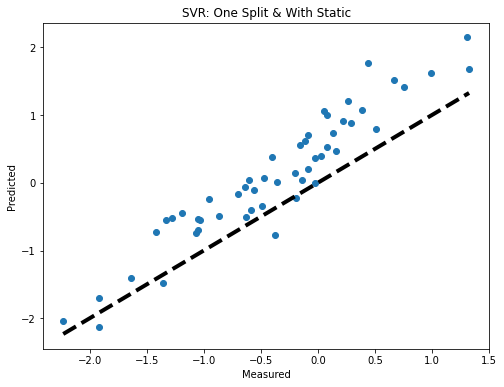

Choosing:  72  top features
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 65 to 74 Years' '% Total Population: 75 to 84 Years'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing'
 '% Employed Civilian Population 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


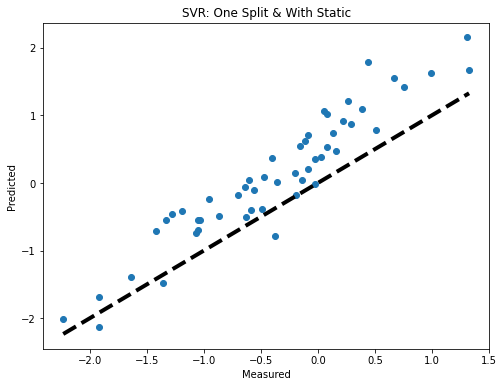

Choosing:  62  top features
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 53, 56, 57, 58, 59, 60, 61]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 65 to 74 Years'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing'
 '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 '% Employed Civilian Population 16 Years and Over

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


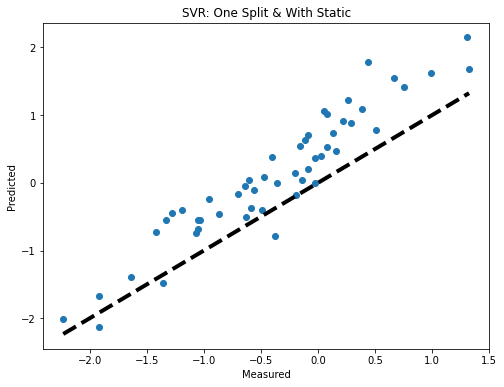

Choosing:  52  top features
[0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 51]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 65 to 74 Years'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 '% Employed Civilian Population 16 Years and Over: Public Administration'
 '% Employed Civilian Population 16 Years and Over1: Private Non-Profit'
 '% Households1: with Earnings' '% Households1: No Earnings'
 '% Households4: with Interest, Dividends, or 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


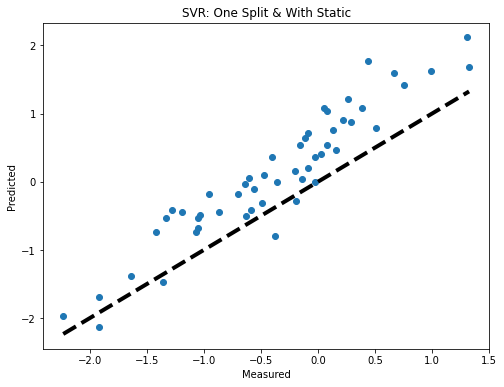

Choosing:  42  top features
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 17, 18, 19, 20, 21, 22, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 35 to 44 Years'
 '% Total Population: 65 to 74 Years'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 '% Employed Civilian Population 16 Years and Over: Public Administration'
 '% Households1: with Earnings' '% Households8: with Retirement Income'
 '% Households8: No Retirement Income'
 '% Families: Income Below Poverty Level: Male Householder, No Wife Present'
 '% Families: Income Below Poverty

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


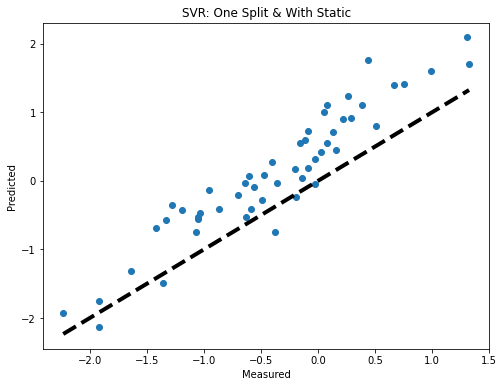

Choosing:  32  top features
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 14, 15, 16, 19, 20, 21, 22, 23, 25, 27, 28, 31]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years' '% Total Population: 65 to 74 Years'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Construction'
 '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 '% Employed Civilian Population 16 Years and Over: Public Administration'
 '% Families: Income Below Poverty Level: Male Householder, No Wife Present'
 '% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years'
 '% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Y

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


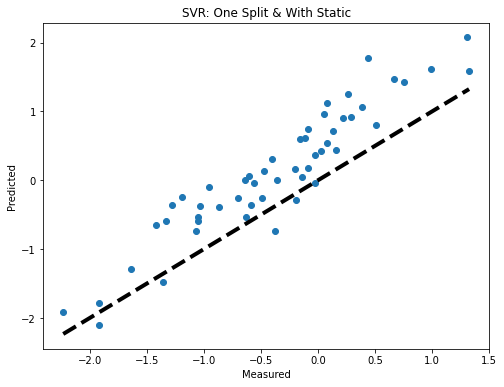

Choosing:  22  top features
[0, 1, 2, 3, 5, 7, 8, 12, 15, 16, 17, 21]
['cases' 'Neighbor cases' 'County total cases'
 '% Total Population: 18 to 24 Years'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 '% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years'
 '% Workers 16 Years and Over: Carpooled'
 '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Taxicab, Motorcycle, Bicycle, or Other Means'
 '% Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes'
 '% Households10: 3-Person Household']
52
MSE: 0.3783176920989525 
r2: 0.5691824258820646 
MAE: 0.5345084467832285 
avg: -0.3739842107738299


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


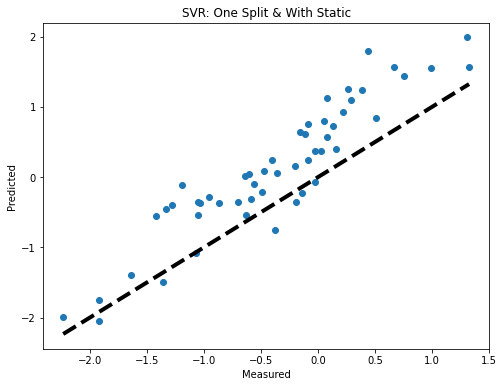

Choosing:  12  top features
[0, 4]
['cases'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present']
52
MSE: 0.45940008076862066 
r2: 0.4004640619802452 
MAE: 0.5944954800742643 
avg: -0.3739842107738299


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


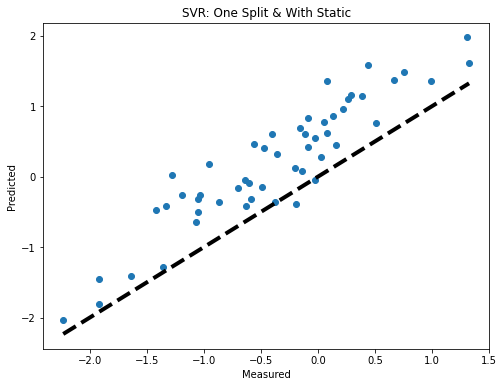

Choosing:  2  top features


AttributeError: ignored

In [51]:
# Feature importance graphs for SVR
def f_importances(coef, names):
    weights = pd.Series(abs(svr_model.coef_[0]))
    weights,names = zip(*sorted(zip(weights,names)))
    weights = weights[::-1]
    names = names[::-1]
    plt.barh(names[:10], weights[:10])
    # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
    # plt.yticks(range(len(names)), names)
    plt.show()
def f_selection(model, kfeatures, feature_names, X_train, y_train):
  sfs1 = sfs(model,
            k_features=kfeatures,
            forward=True,
            floating=False,
            verbose=0,
            scoring='r2',
            cv=5)

  # Perform SFFS
  sfs1 = sfs1.fit(X_train, y_train)
  feat_cols = list(sfs1.k_feature_idx_)
  print(feat_cols)
  print(feature_names[feat_cols])
  return list(feature_names[feat_cols])


month_data_with_census = build_month_data_with_census(census_data)
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = one_time_split(month_data_no_census)
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, svr_model, "SVR: One Split & No Static")
new_features = f_selection(svr_model, 2, feature_names, month_no_census_X_train, month_no_census_y_train)

r2s = []
feature_counts = []
best_features = None
bestr2 = 0

month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = one_time_split(month_data_with_census)
r2_full = one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, svr_model, "SVR: One Split & With Static")

r2s.append(r2_full)
feature_counts.append(month_data_with_census.shape[1])
if r2_full > bestr2:
  bestr2 = r2_full
  best_features = feature_names

num_features = month_data_with_census.shape[1]
while num_features > 10:
  num_features -= 10
  print("Choosing: ",num_features, " top features")
  top_n_features = f_selection(svr_model, num_features, feature_names, month_with_census_X_train, month_with_census_y_train)
  #
  new_census_features = list()
  new_census_features.append('name')
  for feature in top_n_features:
    if feature != 'cases' and feature != 'Neighbor cases' and feature != 'County total cases':
      new_census_features.append(feature)
  
  # Record r2 with these features
  new_census_data = census_data[new_census_features]
  feature_names = np.concatenate((['cases', 'Neighbor cases', 'County total cases'], new_census_data.columns.values[1:]))
  month_data_with_census = build_month_data_with_census(new_census_data)
  month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = one_time_split(month_data_with_census)
  r2_new = one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, svr_model, "SVR: One Split & With Static")
  r2s.append(r2_new)
  feature_counts.append(num_features)

  if r2_new > bestr2:
    bestr2 = r2_new
    best_features = feature_names


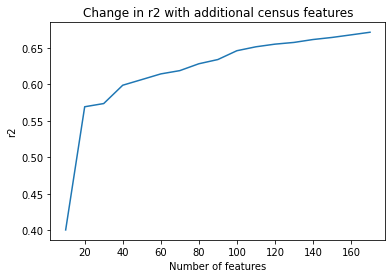

In [54]:
for idx, val in enumerate(feature_counts):
  feature_counts[idx] = val - 2;
plt.plot(feature_counts, r2s)
plt.xlabel('Number of features')
plt.ylabel('r2')
plt.title('Change in r2 with additional census features')
plt.show()



# Gradient Boosting

In [ ]:
gb_param_grid = {
   'n_estimators': [700, 900, 1100],
    'max_depth': [16, 32, 48],
    'min_samples_split': [50, 100, 200],
}

gb_model = GradientBoostingRegressor()
gb_search = GridSearchCV(gb_model, gb_param_grid)

In [ ]:
gb_param = {
    'n_estimators': 700,
    'max_depth': 16,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}

In [ ]:
new_m = GradientBoostingRegressor(**gb_param)

## One split

### No census

In [ ]:
gb_model = GradientBoostingRegressor(**gb_param)
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, gb_model, "GB: One Split & No Census")

### With census

In [ ]:
gb_model = GradientBoostingRegressor(**gb_param)
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, gb_model, "GB: One Split & With Census")

In [ ]:
# gb_search.best_estimator_

In [ ]:
feat_im = np.array(gb_model.feature_importances_)
feat_im_indices = feat_im.argsort()[-10:][::-1]
important_features = feature_names[feat_im_indices]
for i in feat_im_indices:
    print(feature_names[i])
    print(feat_im[i])

plt.figure()
plt.title("Feature importances")
plt.barh(range(len(important_features)), feat_im[feat_im_indices],
       color="r", align="center")
plt.yticks(range(len(important_features)), important_features)
plt.ylim([-1, len(important_features)])
plt.show()

## Multiple Splits

### No census

In [ ]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, gb_model, "GB: Multiple Splits & No Census")

### With census

In [ ]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, gb_model, "GB: Multiple Splits & With Census")

# XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)

In [ ]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, xg_model, "XGB: One Split & No Census")

In [ ]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, xg_model, "XGB: One Split & With Census")

# Scratch Work

In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
        t1 = scale(power_transform(feat.reshape(-1,1)))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    plt.hist(month_data_with_census[:,i])
    plt.title(feature_names[i-1])
    plt.show()